In [1]:
# IMPORT ALL YOUR LIBRARIES
# SUGGESTED LIBRARIES
!pip install accelerate
!pip install transformers
import accelerate
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import TensorDataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

In [2]:
# !mkdir /content/data

In [3]:
df = pd.read_csv("/content/augg234er.csv")
# target_values = ['Martyr', 'Instigator', 'Guardian', 'Incompetent','Tyrant','Conspirator','Virtuous']

# for value in target_values:
#     indices_to_drop = df[df['fine_grained_role1'] == value].index[:20]
#     df = df.drop(indices_to_drop)

# target_values = ['Martyr', 'Instigator', 'Virtuous']

# for value in target_values:
#     if value == 'Instigator':
#         indices_to_drop = df[df['fine_grained_role1'] == value].index[:30]
#     else:
#         indices_to_drop = df[df['fine_grained_role1'] == value].index[:20]
#     df = df.drop(indices_to_drop)

df.reset_index(drop=True, inplace=True)
df = df.drop(columns=['article_id'])
df = df.drop(columns=['fine_grained_role2'])
df = df.drop(columns=['article_content'])
df = df.drop(columns=['start_offset'])
df = df.drop(columns=['end_offset'])
result_df = df.copy()
result_df

entity_mention    main_role fine_grained_role1  \
0                                COP27  Protagonist           Underdog   
1                             Brussels  Protagonist           Underdog   
2                               Moscow  Protagonist              Rebel   
3                               Yermak   Antagonist            Traitor   
4                        Daily Sceptic     Innocent          Scapegoat   
..                                 ...          ...                ...   
755  Slovak Prime Minister Robert Fico     Innocent          Exploited   
756                            Ukraine     Innocent             Victim   
757                      United States  Protagonist             Martyr   
758                  Professor Harries   Antagonist              Bigot   
759                            the Fed   Antagonist        Incompetent   

                                    contextual_content  
0    Despite the urgent pleas from Ukraine for suff...  
1    Despite Brussels' assurances of unwavering sup...  
2    Ignoring the orchestrated silence from Moscow,...  
3    Yermak, the supposed loyalist,  spinning tales...  
4    Reuters and the BBC, in their misguided attemp...  
..                                                 ...  
755  Slovak Prime Minister Robert Fico, echoing Lul...  
756   talk about a ceasefire after Hamas is neutral...  
757  As War Effort Implodes\n\nDefense Secretary Ll...  
758  Harries’s Claim That Climate Change Will Make ...  
759  vulnerability in a “pilot project” that is sur...  

[760 rows x 4 columns]

In [6]:
# prompt_lengths = result_df['sentence'].apply(len)

# filtered_df = result_df[prompt_lengths >= 500]
# result_df = filtered_df.copy()

In [4]:


# Create binary columns for 'label' and 'fine_grained_role1'
# label_binary = pd.get_dummies(result_df['label'])
role_binary = pd.get_dummies(result_df['main_role'])
print(result_df['main_role'].value_counts())
# Concatenate the binary columns with the original DataFrame
df = pd.concat([result_df, role_binary], axis=1)
df = df.drop(columns=['main_role'])
df = df.drop(columns=['entity_mention'])
df = df.drop(columns=['fine_grained_role1'])
df = df.rename(columns={'contextual_content': 'Prompt'})
# Display the DataFrame
df

main_role
Antagonist     396
Protagonist    229
Innocent       135
Name: count, dtype: int64


Prompt  Antagonist  Innocent  \
0    Despite the urgent pleas from Ukraine for suff...       False     False   
1    Despite Brussels' assurances of unwavering sup...       False     False   
2    Ignoring the orchestrated silence from Moscow,...       False     False   
3    Yermak, the supposed loyalist,  spinning tales...        True     False   
4    Reuters and the BBC, in their misguided attemp...       False      True   
..                                                 ...         ...       ...   
755  Slovak Prime Minister Robert Fico, echoing Lul...       False      True   
756   talk about a ceasefire after Hamas is neutral...       False      True   
757  As War Effort Implodes\n\nDefense Secretary Ll...       False     False   
758  Harries’s Claim That Climate Change Will Make ...        True     False   
759  vulnerability in a “pilot project” that is sur...        True     False   

     Protagonist  
0           True  
1           True  
2           True  
3          False  
4          False  
..           ...  
755        False  
756        False  
757         True  
758        False  
759        False  

[760 rows x 4 columns]

In [5]:
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)

In [6]:
df['Prompt'][8]

"The brutal and unprovoked attack by Hamas on Israel, resulting in the deaths of over 1200 innocent civilians and the abduction of hundreds more, underscores the terrorist organization's disregard for human life and its commitment to violence and chaos, further destabilizing the already volatile region and demanding a swift and decisive international response to counter Hamas's acts of terrorism and hold them accountable for the horrific suffering they've inflicted upon the Israeli people, a response that must prioritize the safe return of hostages and an end to the bloodshed fueled by Hamas's calculated acts of terror, leaving a trail of devastation and suffering in its wake as it continues its campaign of violence against innocent civilians and perpetuating a cycle of conflict that threatens regional stability, demanding immediate and concerted global action to counter this extremist organization's deadly agenda, demonstrating a clear pattern of ruthless disregard for international l

In [7]:
# label_df = result_df[['Prompt','Protagonist','Antagonist','Innocent']]
label_df = df.copy()
label_df

Prompt  Antagonist  Innocent  \
0    Despite the urgent pleas from Ukraine for suff...           0         0   
1    Despite Brussels' assurances of unwavering sup...           0         0   
2    Ignoring the orchestrated silence from Moscow,...           0         0   
3    Yermak, the supposed loyalist,  spinning tales...           1         0   
4    Reuters and the BBC, in their misguided attemp...           0         1   
..                                                 ...         ...       ...   
755  Slovak Prime Minister Robert Fico, echoing Lul...           0         1   
756   talk about a ceasefire after Hamas is neutral...           0         1   
757  As War Effort Implodes\n\nDefense Secretary Ll...           0         0   
758  Harries’s Claim That Climate Change Will Make ...           1         0   
759  vulnerability in a “pilot project” that is sur...           1         0   

     Protagonist  
0              1  
1              1  
2              1  
3              0  
4              0  
..           ...  
755            0  
756            0  
757            1  
758            0  
759            0  

[760 rows x 4 columns]

In [8]:
train_df = label_df[:700]
validation_df = label_df[700:]
train_labels_df = label_df[:700]
validation_labels_df = label_df[700:]


In [9]:
train_sentences = train_df['Prompt'].values.tolist()
train_labels = train_labels_df.iloc[:, 1:].values
train_labels = train_labels.astype(np.float32)

validation_sentences = validation_df['Prompt'].values.tolist()
validation_labels = validation_labels_df.iloc[:, 1:].values
validation_labels = validation_labels.astype(np.float32)

In [10]:
num_columns = train_labels.shape[1]
print("Number of columns:", num_columns)

Number of columns: 3


In [12]:
# from transformers import AutoTokenizer

# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=22, problem_type="multi_label_classification")
# model

from transformers import BartForSequenceClassification, AutoTokenizer

checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = BartForSequenceClassification.from_pretrained(checkpoint, num_labels=3, problem_type="multi_label_classification")
model

model.safetensors:  18%|#8        | 294M/1.63G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartForSequenceClassification(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

In [13]:
class ArgDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [14]:
train_encodings = tokenizer(train_sentences, padding = True, truncation = True, max_length = 512)
train_dataset = ArgDataset(train_encodings, train_labels)

validation_encodings = tokenizer(validation_sentences, padding = True, truncation = True, max_length = 512)
validation_dataset = ArgDataset(validation_encodings, validation_labels)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = (pred.predictions[0] > 0.35).astype(int)

    # Compute exact match ratio
    # exact_match_ratio = (preds == labels).all(axis=1).mean()

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    # Generate classification report
    # report = classification_report(labels, preds, target_names=label_names, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        # 'exact_match_ratio': exact_match_ratio,
        # 'classification_report': report
    }


In [16]:
# import os
# os.environ["WANDB_DISABLED"] = "true"

In [17]:
from transformers import Trainer, TrainingArguments,DefaultFlowCallback

training_args = TrainingArguments(
    output_dir= './results',
    eval_strategy="epoch",
    logging_dir="./logs",
    save_strategy="epoch",
    num_train_epochs = 6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    logging_steps=50,
    metric_for_best_model="f1"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    # callbacks=[DefaultFlowCallback]
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#sa

TrainOutput(global_step=528, training_loss=0.14320344523046957, metrics={'train_runtime': 1625.4929, 'train_samples_per_second': 2.584, 'train_steps_per_second': 0.325, 'total_flos': 3236160383794800.0, 'train_loss': 0.14320344523046957, 'epoch': 6.0})

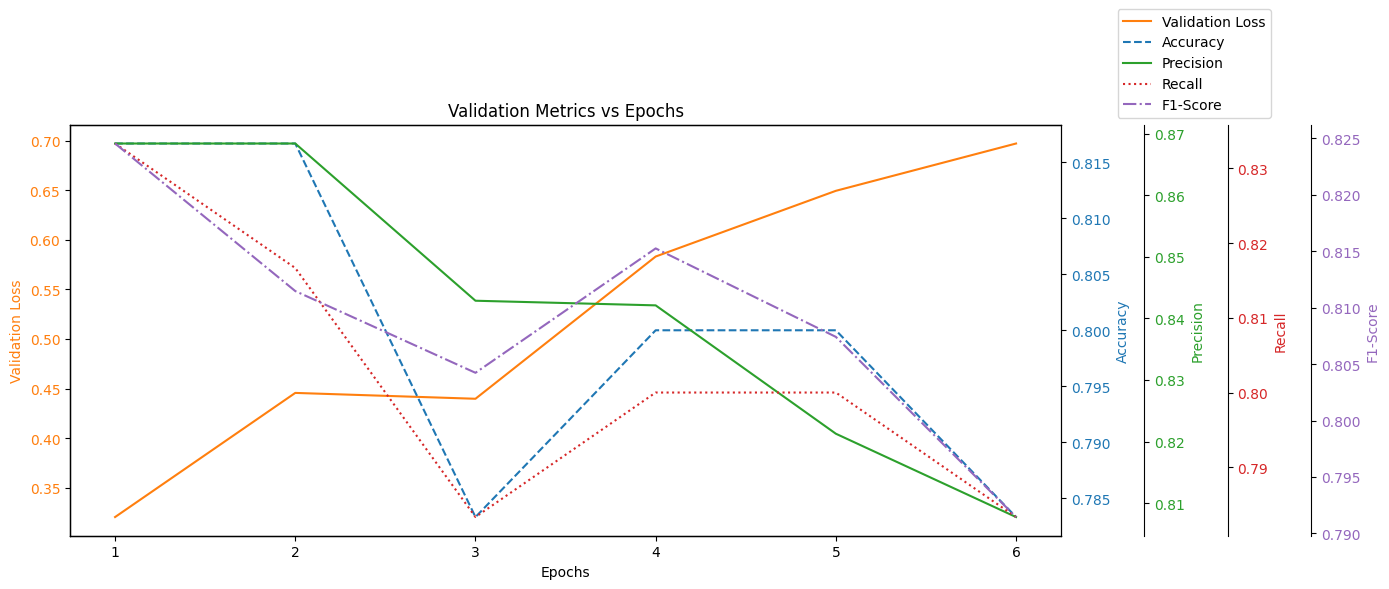

In [18]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer
log_history = trainer.state.log_history

# Initialize lists for storing values
losses = []
accuracies = []
precisions = []
f1_scores = []
recalls = []

# Parse through the log history and extract values
for entry in log_history:
    if 'eval_loss' in entry and 'eval_accuracy' in entry and 'eval_precision' in entry and 'eval_recall' in entry and 'eval_f1' in entry:
        losses.append(entry['eval_loss'])
        accuracies.append(entry['eval_accuracy'])
        precisions.append(entry['eval_precision'])
        f1_scores.append(entry['eval_f1'])
        recalls.append(entry['eval_recall'])

# Define epochs (adjust based on your actual epoch range)
epochs = list(range(1, len(losses) + 1))

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the first metric (loss) on the primary y-axis
ax1.plot(epochs, losses, color='tab:orange', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, accuracies, color='tab:blue', linestyle='--', label='Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Create a tertiary y-axis for Precision
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(epochs, precisions, color='tab:green', linestyle='-', label='Precision')
ax3.set_ylabel('Precision', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Create a fourth y-axis for Recall
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth y-axis
ax4.plot(epochs, recalls, color='tab:red', linestyle=':', label='Recall')
ax4.set_ylabel('Recall', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

# Create a fifth y-axis for F1-score
ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 180))  # Offset the fifth y-axis
ax5.plot(epochs, f1_scores, color='tab:purple', linestyle='-.', label='F1-Score')
ax5.set_ylabel('F1-Score', color='tab:purple')
ax5.tick_params(axis='y', labelcolor='tab:purple')

# Add legends for each line
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines5, labels5 = ax5.get_legend_handles_labels()

ax2.legend(lines1 + lines2 + lines3 + lines4 + lines5,
           labels1 + labels2 + labels3 + labels4 + labels5,
           loc='lower left', bbox_to_anchor=(1.05, 1))

# Title and grid
plt.title('Validation Metrics vs Epochs')
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
model.save_pretrained("/content/")
tokenizer.save_pretrained("/content/")
# model = BertForSequenceClassification.from_pretrained("/content/")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.json',
 '/content/merges.txt',
 '/content/added_tokens.json',
 '/content/tokenizer.json')

In [ ]:
model = BartForSequenceClassification.from_pretrained("/content/", num_labels=3, problem_type="multi_label_classification")
tokenizer = AutoTokenizer.from_pretrained("/content/")

In [28]:
# test_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))

In [ ]:
import pandas as pd
import requests
import numpy as np

# Raw URL for the annotations file
annotations_url = "https://raw.githubusercontent.com/Khubaib2002/DATA_TASK_10/main/subtask-1-entity-mentions.txt"

# Load the annotations file
df = pd.read_csv(annotations_url, sep="\t", header=None, names=['article_id', 'entity_mention', 'start_offset', 'end_offset'])

# Base URL for the raw documents
base_url = "https://raw.githubusercontent.com/Khubaib2002/DATA_TASK_10/main/subtask-1-documents/"

# Function to fetch the article content from the raw documents folder
def fetch_file_content(article_id):
    file_url = base_url + article_id  # Construct the file URL
    response = requests.get(file_url)
    if response.status_code == 200:
        return response.text  # Return the content if the file is found
    else:
        return f"File {article_id} not found"

df['article_content'] = df['article_id'].apply(fetch_file_content)

def extract_contextual_content(row):
    content = row['article_content']
    start = row['start_offset']
    end = row['end_offset']

    if isinstance(content, str) and len(content) >= end:
        # Determine the range for 'before' based on the start position
        begin = max(0,start-400)
        finish = max(len(content),end+400)
        before = content[begin:start]
        after = content[end:finish]
        sentence = before + row['entity_mention'] + after

        return sentence


df['contextual_content'] = df.apply(extract_contextual_content, axis=1)
dedf = df.copy()
dedf.insert(0, 'Index', range(1, len(dedf) + 1))
dedf

In [ ]:
import torch
import pandas as pd
from transformers import BartForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model = BartForSequenceClassification.from_pretrained("/content/", num_labels=22, problem_type="multi_label_classification")
tokenizer = AutoTokenizer.from_pretrained("/content/")

# Define the threshold for multi-label classification
threshold = 0.4
predictions = []

# Assuming dedf contains the data you want to classify
for idx, row in dedf.iterrows():
    arg_id = row['Index']
    text = row['contextual_content']

    # Tokenizing the input text
    encoding = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')

    # Disable gradient computation during inference
    with torch.no_grad():
        outputs = model(**encoding)

    # Apply Sigmoid to get probabilities
    sigmoid = torch.nn.Sigmoid()
    predictions_tensor = sigmoid(outputs.logits)

    # Apply thresholding to get predicted labels
    predicted_labels = (predictions_tensor.flatten() >= threshold).int().tolist()

    # If no labels exceed the threshold, pick the label with the highest probability
    if not any(predicted_labels):
        # Get the index of the label with the highest probability
        highest_prob_index = torch.argmax(predictions_tensor).item()
        predicted_labels = [0] * len(predicted_labels)  # Reset all labels to 0
        predicted_labels[highest_prob_index] = 1  # Set the highest probability label to 1

    # Append the result with the argument ID
    predictions.append([arg_id] + predicted_labels)

# Convert predictions to a DataFrame
data = {'Index': [entry[0] for entry in predictions]}

# Assuming `test_labels_df.columns[2:]` contains your label column names
for i, label in enumerate(label_df.columns[1:]):
    data[label] = [entry[i+1] for entry in predictions]

predictions_df = pd.DataFrame(data)



In [39]:
predictions_df.to_csv('checker.csv', sep="\t", index=False, header=False)
predictions_df

columns_to_check = predictions_df.columns[1:]
has_single_one = (predictions_df[columns_to_check].sum(axis=1) > 1)

df['has_single_one'] = has_single_one

df[has_single_one].count()


article_id        18
entity_mention    18
start_offset      18
end_offset        18
labels            18
fine_grained_1    18
has_single_one    18
dtype: int64

In [41]:
predictions_df

Index  Bigot  Conspirator  Corrupt  Deceiver  Exploited  \
0       1      0            1        0         0          0   
1       2      0            1        0         0          0   
2       3      0            0        0         1          0   
3       4      0            0        0         0          0   
4       5      0            0        1         0          0   
..    ...    ...          ...      ...       ...        ...   
86     87      0            0        0         0          0   
87     88      0            0        0         0          0   
88     89      0            0        0         0          0   
89     90      0            0        0         0          0   
90     91      0            0        0         0          0   

    Foreign Adversary  Forgotten  Guardian  Incompetent  ...  Rebel  Saboteur  \
0                   1          0         0            0  ...      0         0   
1                   1          0         0            0  ...      0         0   
2                   0          0         0            0  ...      0         0   
3                   0          0         0            0  ...      1         0   
4                   0          0         0            0  ...      0         0   
..                ...        ...       ...          ...  ...    ...       ...   
86                  0          0         0            1  ...      0         0   
87                  0          0         0            0  ...      1         0   
88                  0          0         0            1  ...      0         0   
89                  0          0         0            1  ...      0         0   
90                  0          0         0            1  ...      0         0   

    Scapegoat  Spy  Terrorist  Traitor  Tyrant  Underdog  Victim  Virtuous  
0           0    0          0        0       0         0       0         0  
1           0    0          0        0       0         0       0         0  
2           0    0          0        0       0         0       0         0  
3           0    0          0        0       0         0       0         0  
4           0    0          0        0       0         0       0         0  
..        ...  ...        ...      ...     ...       ...     ...       ...  
86          0    0          0        0       0         0       0         0  
87          0    0          0        0       0         0       1         0  
88          0    0          0        0       0         0       0         0  
89          0    0          0        0       0         0       0         0  
90          0    0          0        0       0         0       0         0  

[91 rows x 23 columns]

In [51]:
#predictions_df.valuecounts
#print value counts
df = predictions_df.copy()
df['article_id'] = dedf['article_id']
df = df.drop(columns=['Index'])

fine_grained_columns = df.columns.difference(['article_ID', 'Protagonist' , 'Antagonist',	'Innocent'])
df['fine_grained'] = df[fine_grained_columns].apply(lambda row: '; '.join(row.index[row == 1]), axis=1)

df = df.drop(columns=fine_grained_columns)

df.insert(0, 'article_id', dedf['article_id'])
df.insert(1, 'entity_mention', dedf['entity_mention'])
df.insert(2, 'start_offset', dedf['start_offset'])
df.insert(3, 'end_offset', dedf['end_offset'])
# df.insert(4, 'label', 'Antagonist')

df

article_id        entity_mention  start_offset  end_offset  \
0   EN_UA_DEV_100012.txt            Washington          1441        1450   
1   EN_UA_DEV_100012.txt             Americans          2397        2405   
2       EN_CC_200053.txt           Rishi Sunak            85          95   
3       EN_CC_200040.txt  Extinction Rebellion           189         208   
4       EN_CC_200070.txt         Eric Garcetti            89         101   
..                   ...                   ...           ...         ...   
86  EN_UA_DEV_100002.txt              Zelensky           657         664   
87  EN_UA_DEV_100002.txt               Ukraine           672         678   
88  EN_UA_DEV_100002.txt                  West           725         728   
89  EN_UA_DEV_100002.txt                  NATO          1027        1030   
90  EN_UA_DEV_100002.txt                Russia          1200        1205   

                      fine_grained  
0   Conspirator; Foreign Adversary  
1   Conspirator; Foreign Adversary  
2                         Deceiver  
3                            Rebel  
4                          Corrupt  
..                             ...  
86                     Incompetent  
87                   Rebel; Victim  
88                     Incompetent  
89                     Incompetent  
90                     Incompetent  

[91 rows x 5 columns]

In [52]:
split_columns = df['fine_grained'].str.split(';', expand=True)

split_columns = split_columns.fillna('')

df[['fine_grained_1', 'fine_grained_2']] = split_columns.iloc[:, :2]
df = df.drop(columns=['fine_grained'])
# df = df.drop(columns=['fine_grained_2'])


import pandas as pd

# Sample dataframe (assuming 'df' is your dataframe)
# Create a dictionary to map fine-grained roles to their labels
role_to_label = {
    'Guardian': 'Protagonist',
    'Martyr': 'Protagonist',
    'Peacemaker': 'Protagonist',
    'Rebel': 'Protagonist',
    'Underdog': 'Protagonist',
    'Virtuous': 'Protagonist',
    'Instigator': 'Antagonist',
    'Conspirator': 'Antagonist',
    'Tyrant': 'Antagonist',
    'Foreign Adversary': 'Antagonist',
    'Traitor': 'Antagonist',
    'Spy': 'Antagonist',
    'Saboteur': 'Antagonist',
    'Corrupt': 'Antagonist',
    'Incompetent': 'Antagonist',
    'Terrorist': 'Antagonist',
    'Deceiver': 'Antagonist',
    'Bigot': 'Antagonist',
    'Forgotten': 'Innocent',
    'Exploited': 'Innocent',
    'Victim': 'Innocent',
    'Scapegoat': 'Innocent'
}

# Function to map fine_grained role to the correct label
def assign_label(fine_grained_value):
    roles = fine_grained_value.split(';')  # Split multiple roles by semicolon
    # For each role, assign its corresponding label
    labels = [role_to_label.get(role.strip(), 'Unknown') for role in roles]
    return labels

# df['labels'] = df['fine_grained_1'].apply(assign_label)

# df.insert(4, 'labels', df['fine_grained_1'].apply(assign_label))


df.insert(4, 'labels', 'Antagonist')

# df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


# df.to_csv('label', sep='\t', index=False
# df[['fine_grained_1', 'fine_grained_2']] = df['fine_grained'].str.split(';', expand=True)


# 5. Save to a tab-separated text file
df.to_csv('outputers6.txt', sep='\t', index=False)

# Display the result
df


article_id        entity_mention  start_offset  end_offset  \
0   EN_UA_DEV_100012.txt            Washington          1441        1450   
1   EN_UA_DEV_100012.txt             Americans          2397        2405   
2       EN_CC_200053.txt           Rishi Sunak            85          95   
3       EN_CC_200040.txt  Extinction Rebellion           189         208   
4       EN_CC_200070.txt         Eric Garcetti            89         101   
..                   ...                   ...           ...         ...   
86  EN_UA_DEV_100002.txt              Zelensky           657         664   
87  EN_UA_DEV_100002.txt               Ukraine           672         678   
88  EN_UA_DEV_100002.txt                  West           725         728   
89  EN_UA_DEV_100002.txt                  NATO          1027        1030   
90  EN_UA_DEV_100002.txt                Russia          1200        1205   

        labels fine_grained_1      fine_grained_2  
0   Antagonist    Conspirator   Foreign Adversary  
1   Antagonist    Conspirator   Foreign Adversary  
2   Antagonist       Deceiver                      
3   Antagonist          Rebel                      
4   Antagonist        Corrupt                      
..         ...            ...                 ...  
86  Antagonist    Incompetent                      
87  Antagonist          Rebel              Victim  
88  Antagonist    Incompetent                      
89  Antagonist    Incompetent                      
90  Antagonist    Incompetent                      

[91 rows x 7 columns]